In [ ]:
# Run once, restart kernel and proceed with the next cell
%pip install --upgrade ipywidgets

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
import json
from pprint import pprint

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import training
from training import load_config, generate_basic_dataloader, generate_sppf_dataloader, get_model, train_loop, cal_regression_metrics
from utils.preprocessing import load_image, apply_img_preprocessing

from inference import load_saved_model, pred_degradation_value

# Training

In [6]:
config_path = "./configs/cnn.yaml"
config = load_config(config_path)
pprint(config,)

{'dataset_loc': {'train': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51_degradation_values.csv',
                           'img_dir': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51'},
                 'val': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c_degradation_values.csv',
                         'img_dir': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c'}},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_dim': 1},
 'results_loc': 'experiment_results/',
 'training': {'batch_size': 1,
              'learning_rate': 0.05,
              'num_epochs': 2,
              'num_workers': 2,
              'resume_checkpoint': None,
              'save_checkpoint_freq': 1}}


In [ ]:
# copy paste config here to edit and experiment
{'dataset_loc': {'train': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51_degradation_values.csv',
                           'img_dir': '../damage_ratio_calc_data/segmented_objects/183_jpg.rf.c3a79aad316f75fe23536c3bbbd6da51'},
                 'val': {'degradation_values_csv': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c_degradation_values.csv',
                         'img_dir': '../damage_ratio_calc_data/segmented_objects/184_jpg.rf.9edad8ca8d25dc9949b48968cca6e41c'}},
 'enable_cuda': True,
 'model': {'in_channels': 3, 'out_dim': 1},
 'results_loc': 'experiment_results/',
 'training': {'batch_size': 1,
              'learning_rate': 0.05,
              'num_epochs': 2,
              'num_workers': 2,
              'resume_checkpoint': None,
              'save_checkpoint_freq': 1}}

In [7]:
# get required config parameters
model_config = config["model"]
train_config = config["training"]
dataset_config = config["dataset_loc"]

In [8]:
if config["enable_cuda"]:
    training.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using DEVICE: {training.DEVICE}")

Using DEVICE: cuda


In [9]:
# update preprocessing config if required
# resize_height, resize_width = preprocess_config["resize_height"], preprocess_config["resize_height"]

# # in case one wants to try out different transformations
# img_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((resize_height, resize_width)),   # ensure resize same is used for mask by setting preprocess_config
#     transforms.ToTensor()
# ])

# generate train data loader
train_loader, train_size = generate_sppf_dataloader(image_dir=dataset_config["train"]["img_dir"],
                                               degradation_values_csv=dataset_config["train"]["degradation_values_csv"],
                                               batch_size=train_config["batch_size"],
                                               num_workers=train_config["num_workers"], transform=None)   # send new transform here if required

# generate validation data loader
val_loader, val_size = generate_sppf_dataloader(image_dir=dataset_config["val"]["img_dir"],
                                           degradation_values_csv=dataset_config["val"]["degradation_values_csv"],
                                           batch_size=train_config["batch_size"],
                                           num_workers=train_config["num_workers"], transform=None)

print(f"Train Dataset loaded. #samples: {train_size}")
print(f"Validation Dataset loaded. #samples: {val_size}")

Train Dataset loaded. #samples: 23
Validation Dataset loaded. #samples: 18


Image batch shape: torch.Size([1, 3, 37, 34])
Degradation value: 0.0


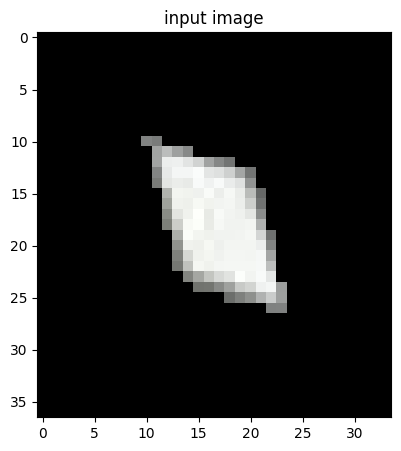

In [10]:
# Ensure that we are getting correct data from data loaders
batch_img, degradation_values = next(iter(train_loader))

print("Image batch shape:", batch_img.shape) 
# print("Degradation value:", degradation_values.shape) 

sample_img = batch_img[0].numpy()   # (c, h, w)
sample_img = sample_img.transpose(1, 2, 0)

# sample_mask = batch_mask[0].numpy()   # (c, h, w)
# sample_mask = np.squeeze(sample_mask) # (h, w)

fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(sample_img)
ax.set_title("input image")

print("Degradation value:", degradation_values[0].item())

In [11]:
# Initializing the model, loss function, and the optimizer
model_name = "cnn_sppf"
model = get_model(model_name, in_channels=model_config['in_channels'], out_dim=model_config['out_dim'])
model = model.to(training.DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=train_config["learning_rate"])

checkpoint_path = train_config["resume_checkpoint"]
if checkpoint_path is not None:
    model.load_state_dict((torch.load(checkpoint_path, weights_only=True)))

In [12]:
# train the model
train_loop(model=model, loss_fn=criterion, optimizer=optimizer,
           train_loader=train_loader, val_loader=val_loader,
           num_epochs=train_config["num_epochs"], save_path=config["results_loc"],
           checkpoint_freq=train_config["save_checkpoint_freq"])

Training Started...


epoch: 0:   0%|          | 0/23 [00:00<?, ?it/s]

d:\Microconda3\envs\retro\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/2], Train Loss: 4.9901, Val Loss: 0.2526, Epoch execution time: 19.29 sec


epoch: 1:   0%|          | 0/23 [00:00<?, ?it/s]

Epoch [2/2], Train Loss: 0.1629, Val Loss: 0.1359, Epoch execution time: 19.3 sec
   Learning curve saved to experiment_results/train_log\learning_curve_2025-03-13_18-02-43.png
   Learning history saved to experiment_results/train_log\learning_history_2025-03-13_18-02-43.json
Model saved at: experiment_results/checkpoints\cnn_sppf_final_2025-03-13_18-02-43.pth
Training Completed! Total time: 0.6458 min


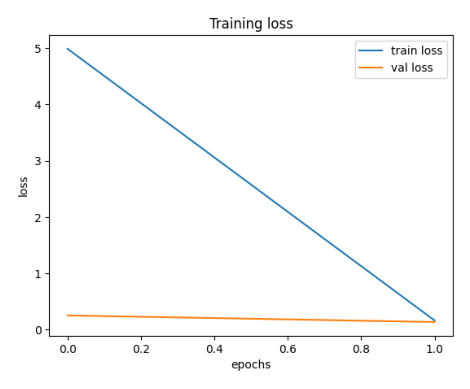

In [13]:
# open saved learning curve
plot_saved_path = "experiment_results/train_log/learning_curve_2025-03-13_18-02-43.png"
img = load_image(plot_saved_path)
plt.imshow(img)
plt.axis("off")
plt.show()

In [31]:
# Evaluate model performance at end of training using different losses
train_losses = cal_regression_metrics(model, train_loader)
val_losses = cal_regression_metrics(model, val_loader)

print(f"Train Loss: {train_losses}")
print(f"Validation Loss: {val_losses}")

Train Loss: {'MSE': 0.13643937167371772, 'MAE': 0.33485133775874326, 'R2': -0.1321757049790231}
Validation Loss: {'MSE': 0.13589347612213384, 'MAE': 0.33169368333700633, 'R2': -0.013017451932746615}


# Inference

In [16]:
saved_weight_path = "experiment_results/checkpoints/cnn_sppf_final_2025-03-13_18-02-43.pth"

model_name = "cnn_sppf"
model_config = {'in_channels': 3, 'out_dim': 1}

In [14]:
# update preprocessing according to training
resize_height, resize_width = 720, 1280

# Define the image transformations
img_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((resize_height, resize_width)),   # ensure resize is same as used during training for loaded model 
    transforms.ToTensor()
])

In [17]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [18]:
# initialize and load saved model
model = load_saved_model(model_name=model_name, saved_weight_path=saved_weight_path, **model_config)
model = model.to(DEVICE)

Saved weights loaded


Test image shape: (61, 54, 3)


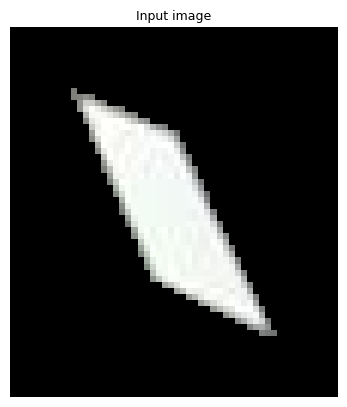

In [20]:
test_img_path = "../damage_ratio_calc_data/segmented_objects/191_jpg.rf.e27c030e763e58ce48964e670158b6e7/191_jpg.rf.e27c030e763e58ce48964e670158b6e7_object_4.png"
test_img = load_image(test_img_path)
print("Test image shape:", test_img.shape)
plt.imshow(test_img)
plt.axis("off")
plt.title("Input image", fontsize=9)
plt.show()

In [24]:
pred_val = pred_degradation_value(model=model, test_img=test_img, img_transform=None, add_batch_dim=True, device=DEVICE)
print("Predicticted degradation value:", pred_val)

Predicticted degradation value: 0.370121568441391
